In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
import seaborn as sns
import sklearn

from sklearn.preprocessing import normalize
from torchvision.datasets import CIFAR10, CIFAR100

from utils import load_features

%matplotlib inline



sns.set_context("paper", font_scale=4.0)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["text.usetex"] = True

%config Completer.use_jedi = False

In [2]:
cifar10 = CIFAR10(root="~/pytorch_datasets/", download=True, train=False)
cifar100 = CIFAR100(root="~/pytorch_datasets/", download=True, train=True)

id2classes = {
    "cifar10": cifar10.classes,
    "cifar100": cifar100.classes,
}


Files already downloaded and verified
Files already downloaded and verified


In [3]:
features = load_features(sub_sampled=False)

## Norm

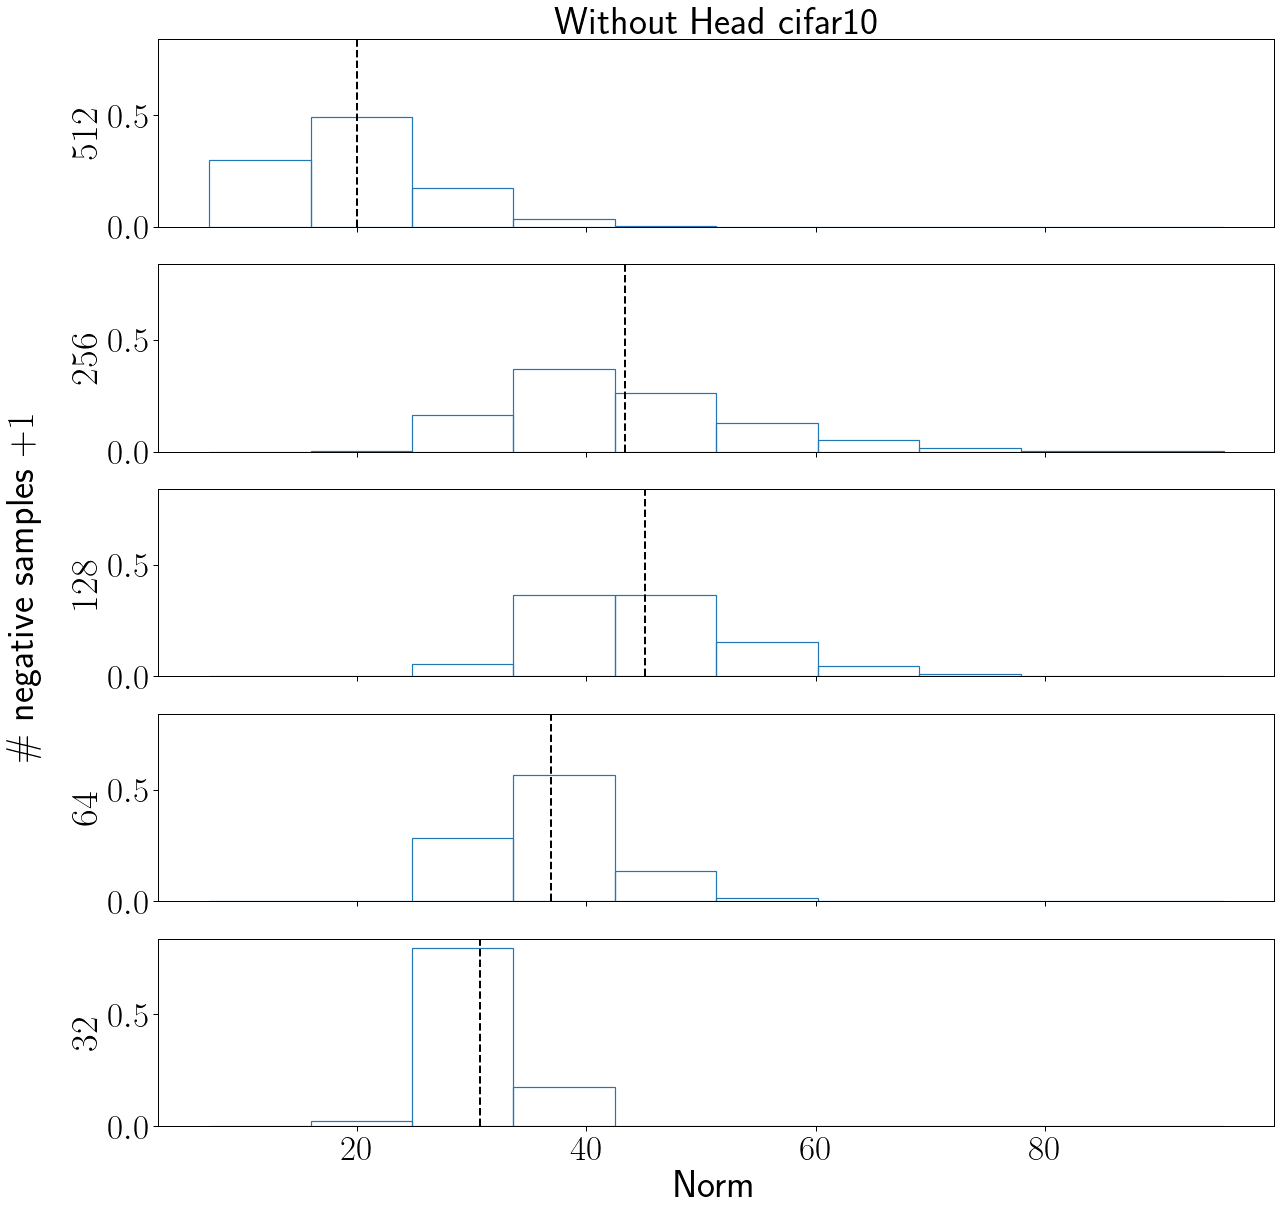

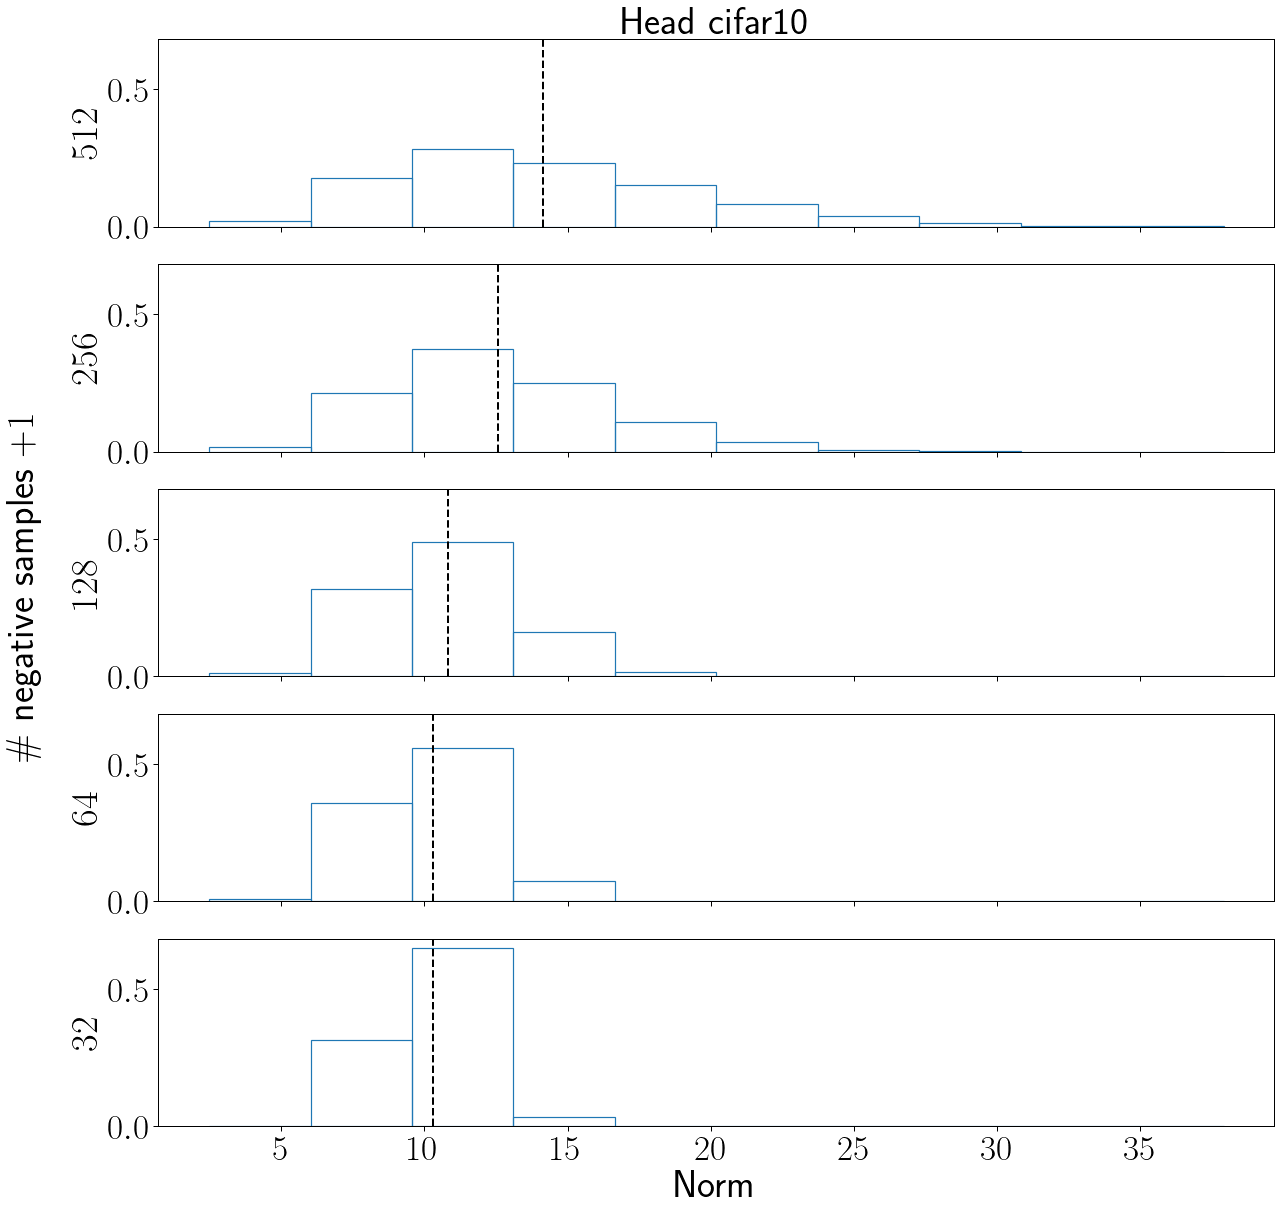

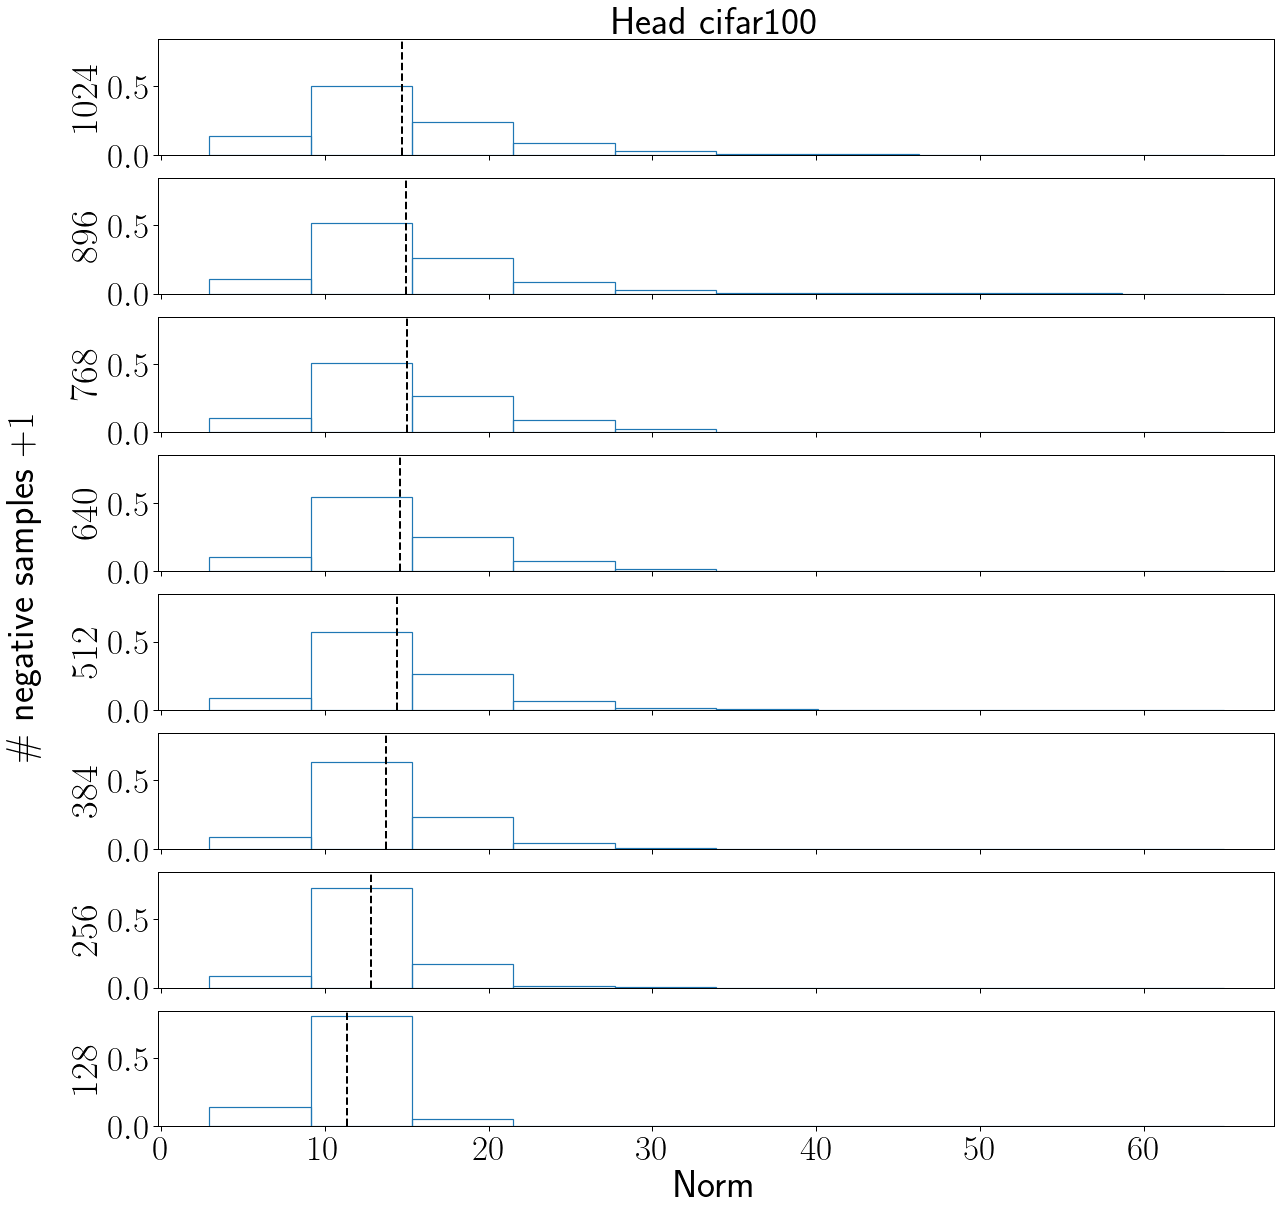

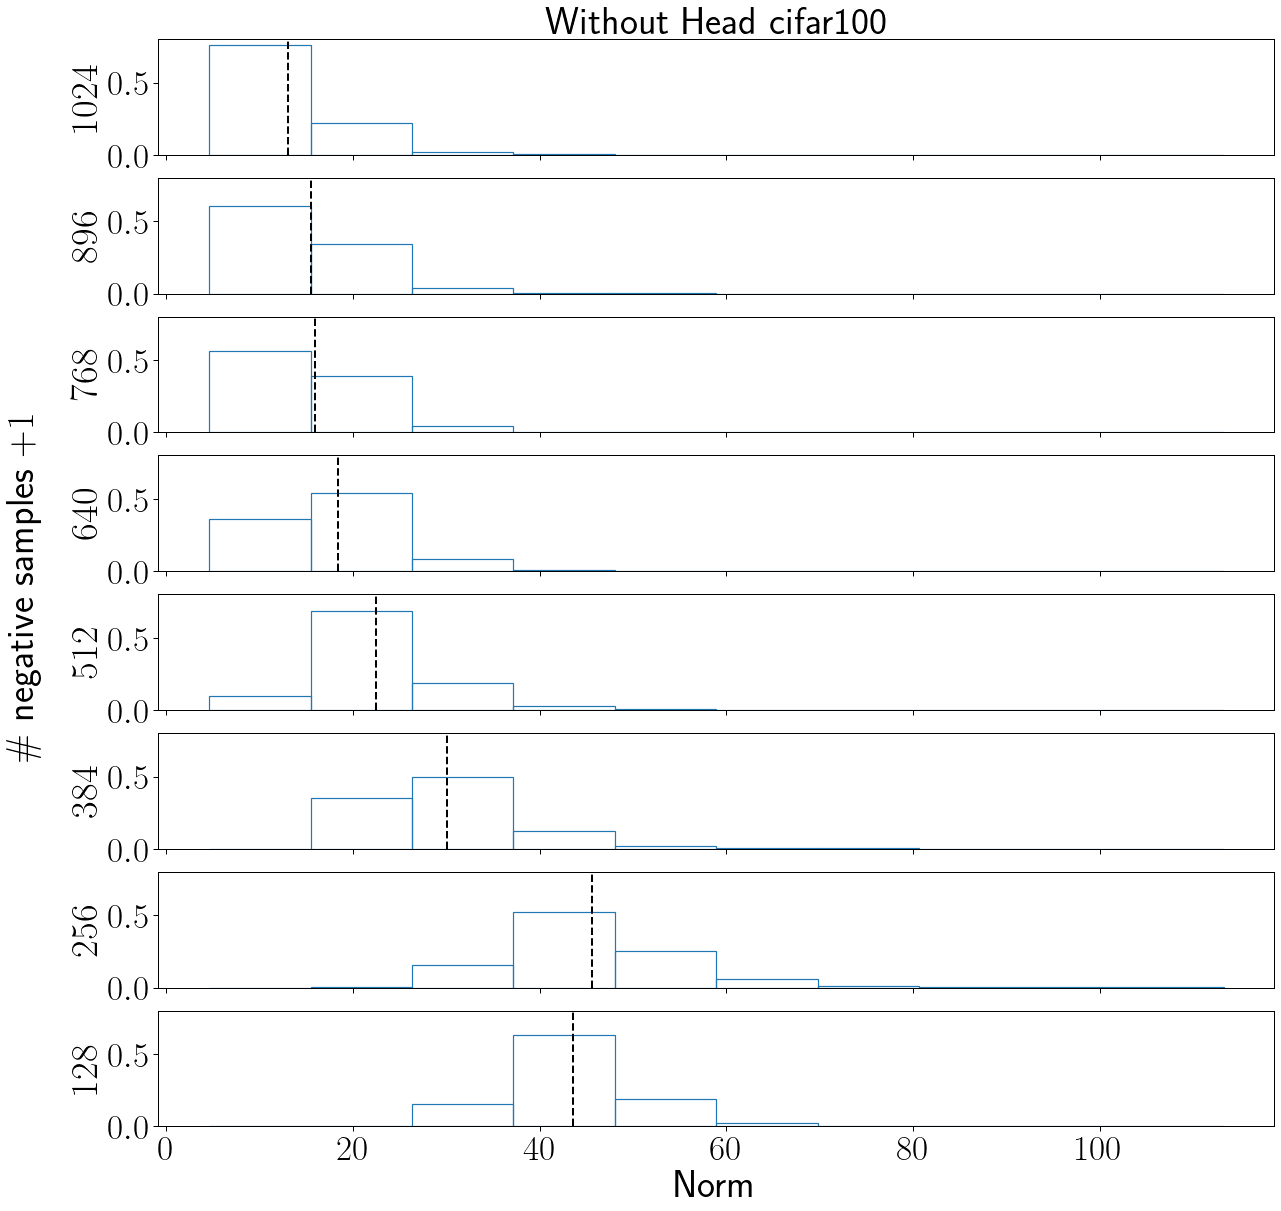

In [4]:
seed = 7

for dataset, features_by_dataset in features.items():

    for head_info, f_d_h in features_by_dataset.items():
        negs = list(sorted(f_d_h[seed]))
        fig, axes = plt.subplots(len(f_d_h[seed]), 1, figsize=(20, 20), sharex=True, sharey=True)
        norms = []
        norm_max = 0.
        norm_min = 10e7
        for i, neg in enumerate(negs[::-1]):
            # use only use seed value
            X_train = f_d_h[seed][neg][0]

            norm = np.sqrt(np.sum(X_train ** 2, axis=1))
            norms.append(norm)
            norm_max = max(norm_max, np.max(norm))
            norm_min = min(norm_min, np.min(norm))            
        
        for i, norm in enumerate(norms):
            num_bins = int(np.log(len(norm)))

            sns.histplot(norm, bins=num_bins, stat="probability", ax=axes[i], fill=False, binrange=(norm_min, norm_max))
            axes[i].axvline(norm.mean(), color="k", linestyle="dashed", linewidth=2.)

        for i, neg in enumerate(negs[::-1]):
            axes[i].set_xlabel("")
            axes[i].set_ylabel("" + "${}$".format(neg))

        axes[-1].set_xlabel("Norm")

        fig.text(0.02, 0.5, "\# negative samples $+ 1$", va="center", rotation="vertical")

        fname = "../../doc/figs/norm_hist_{}_{}_seed-{}.pdf".format(head_info, dataset.upper().replace("1", "-1"), seed)
        plt.savefig(fname)
        axes[0].set_title("{} {}".format(head_info, dataset))
        plt.show()


# Cosine

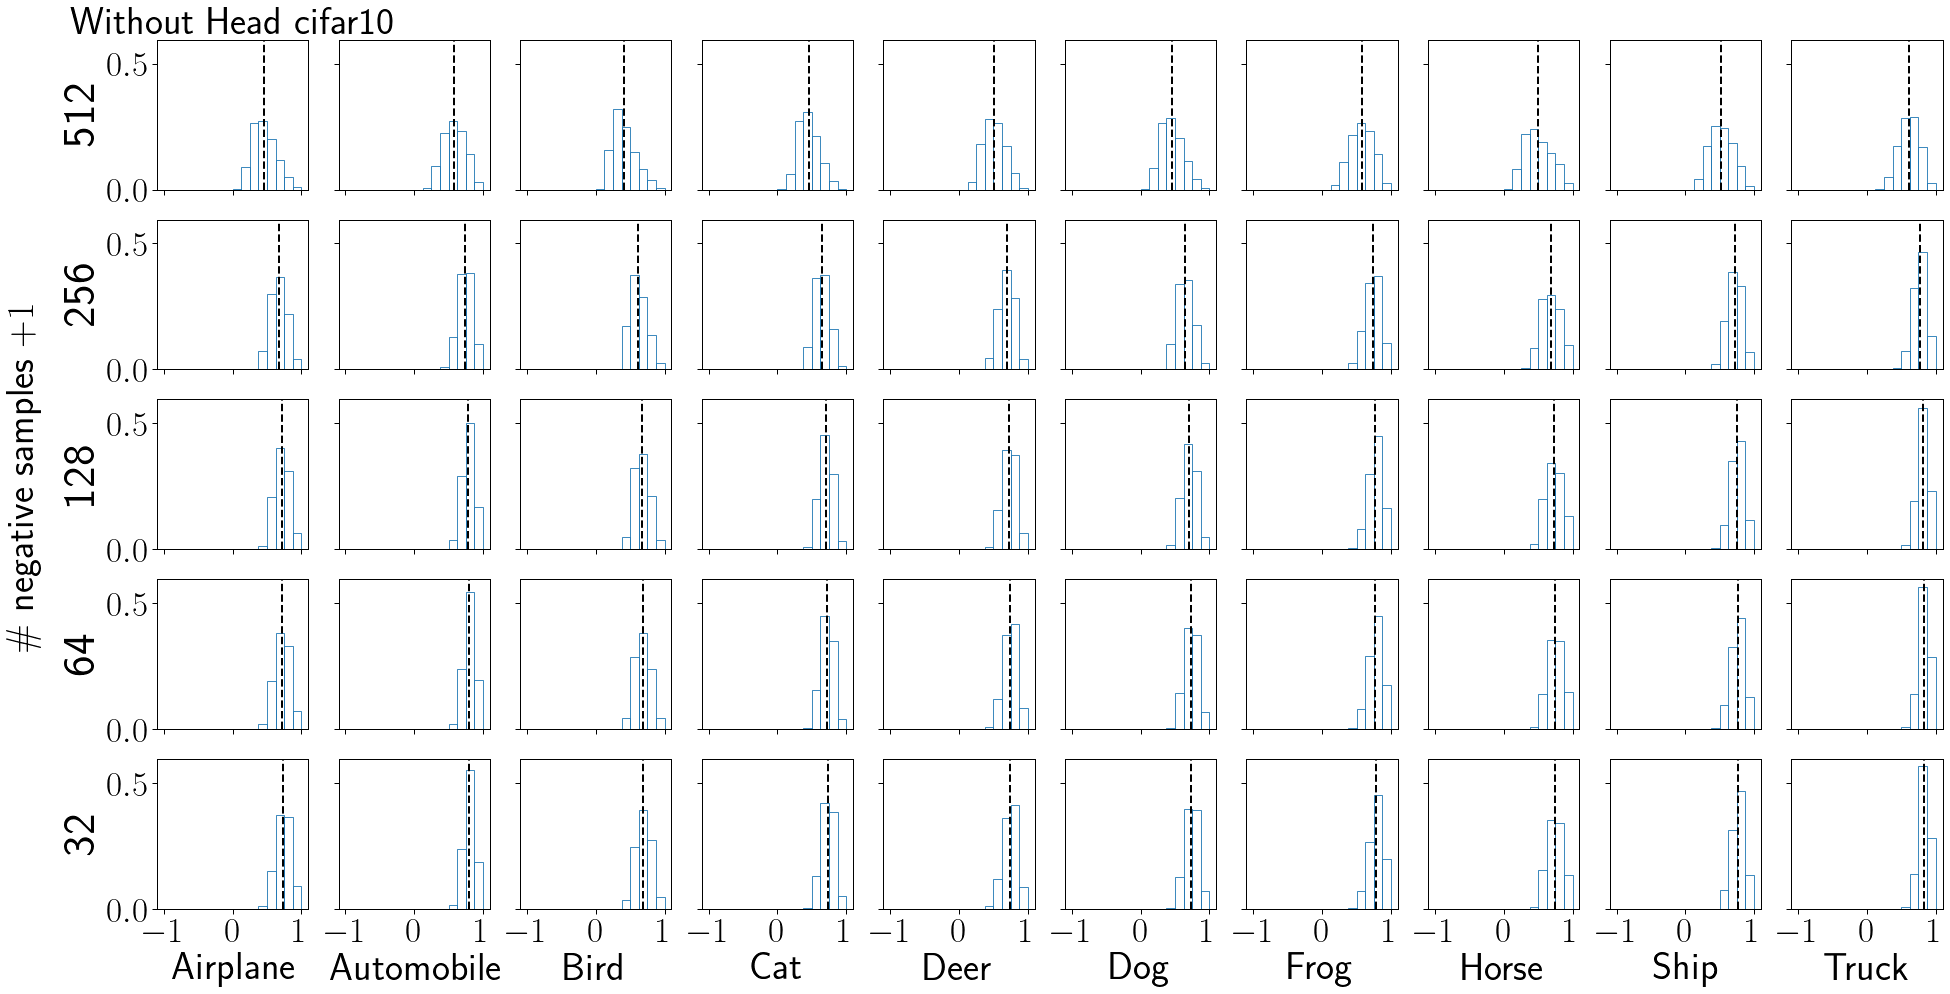

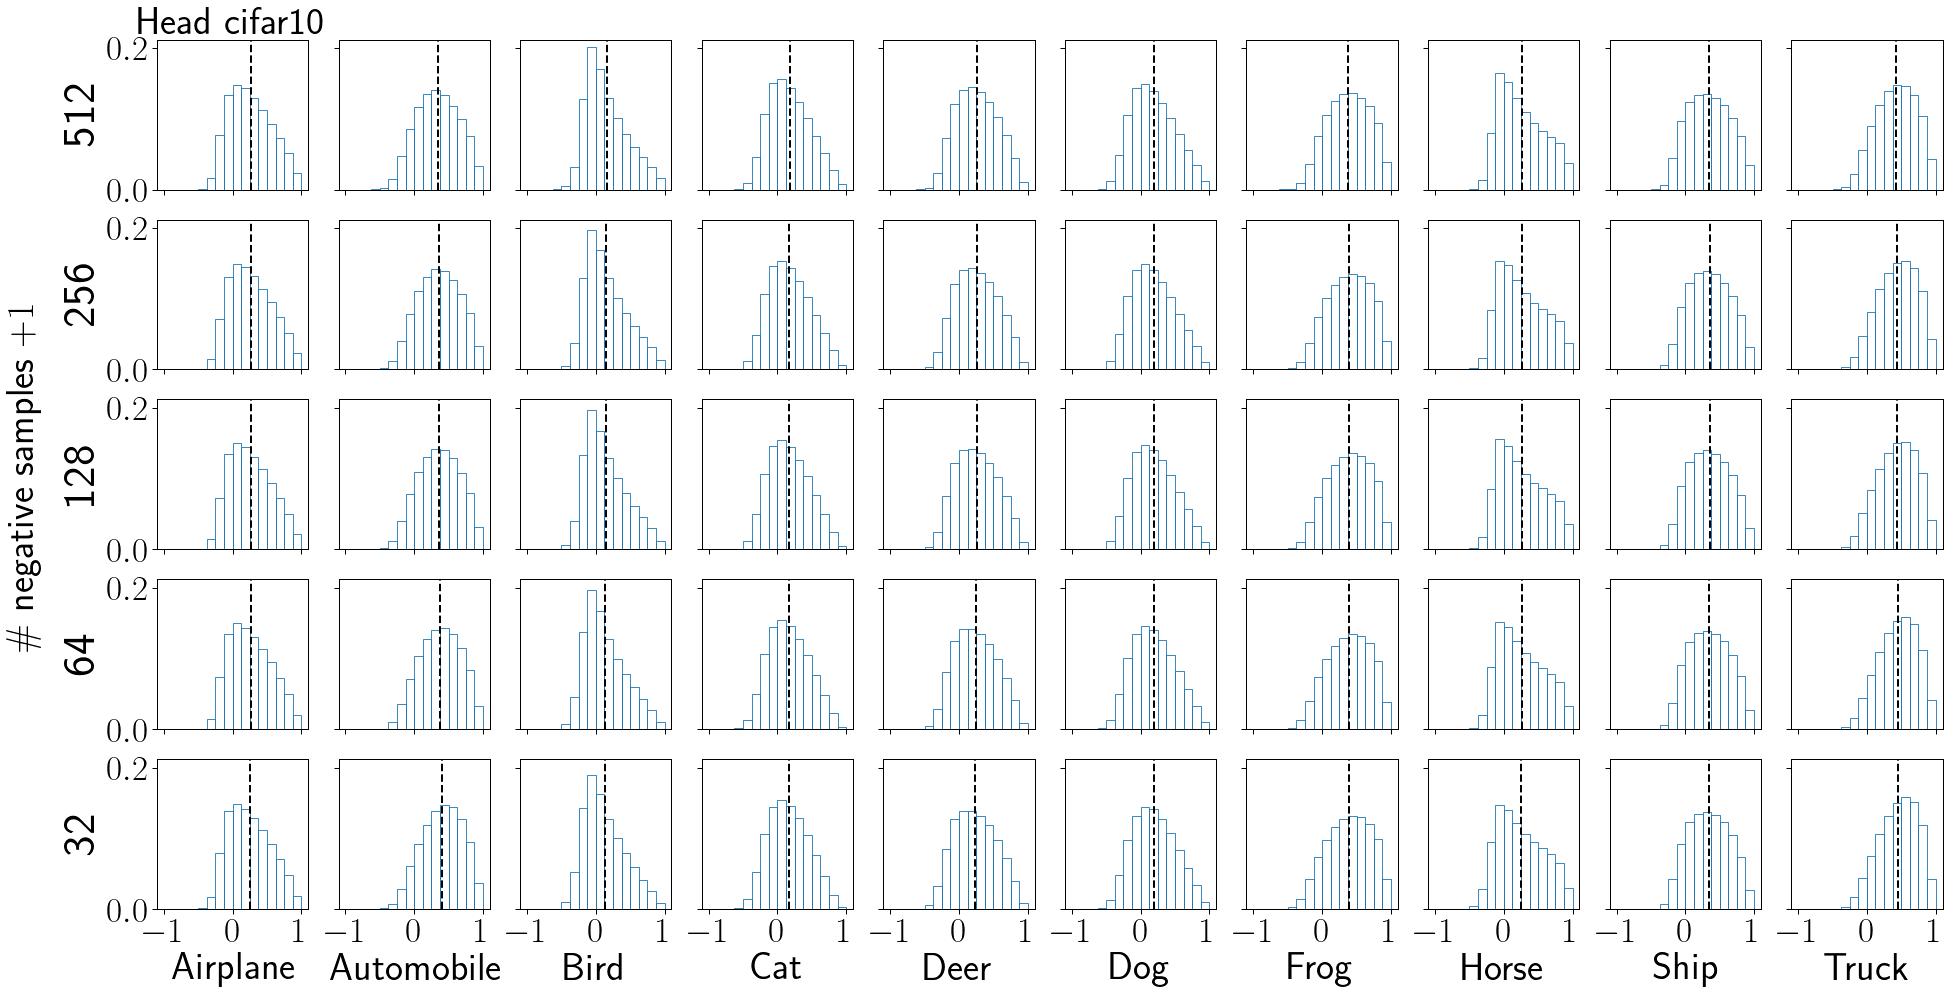

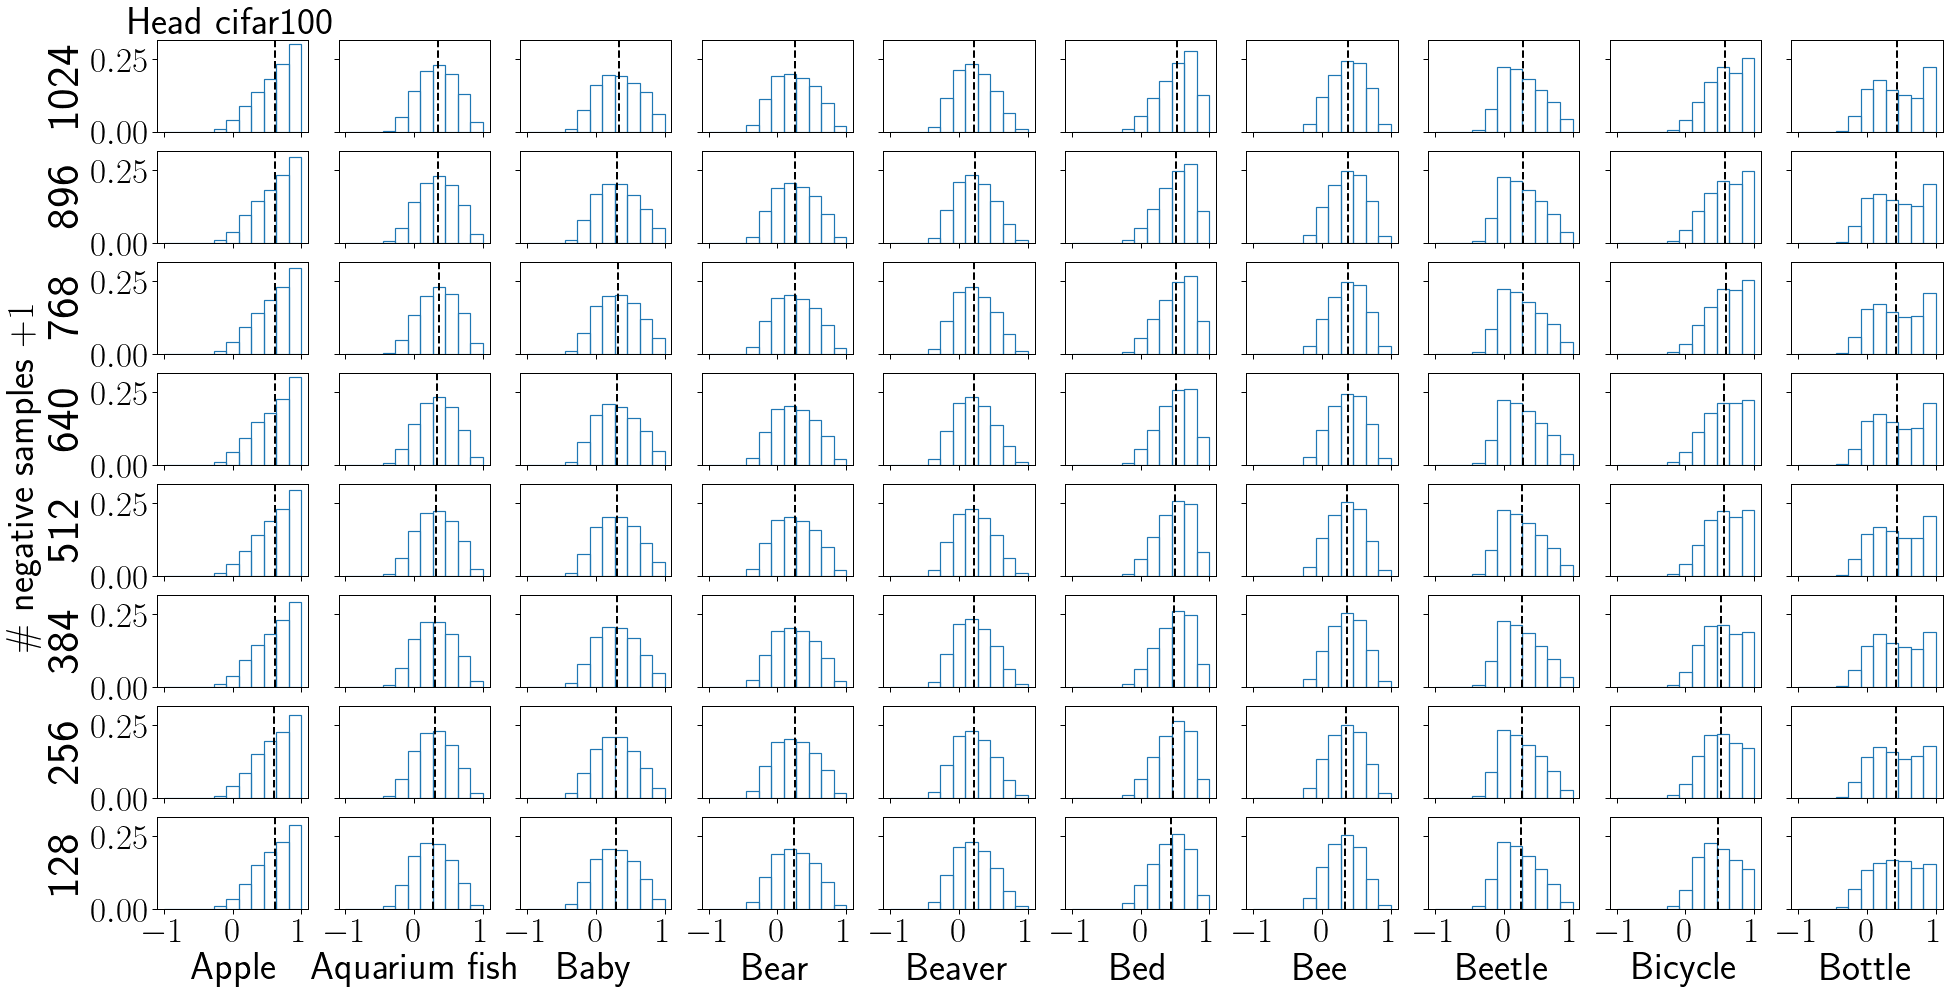

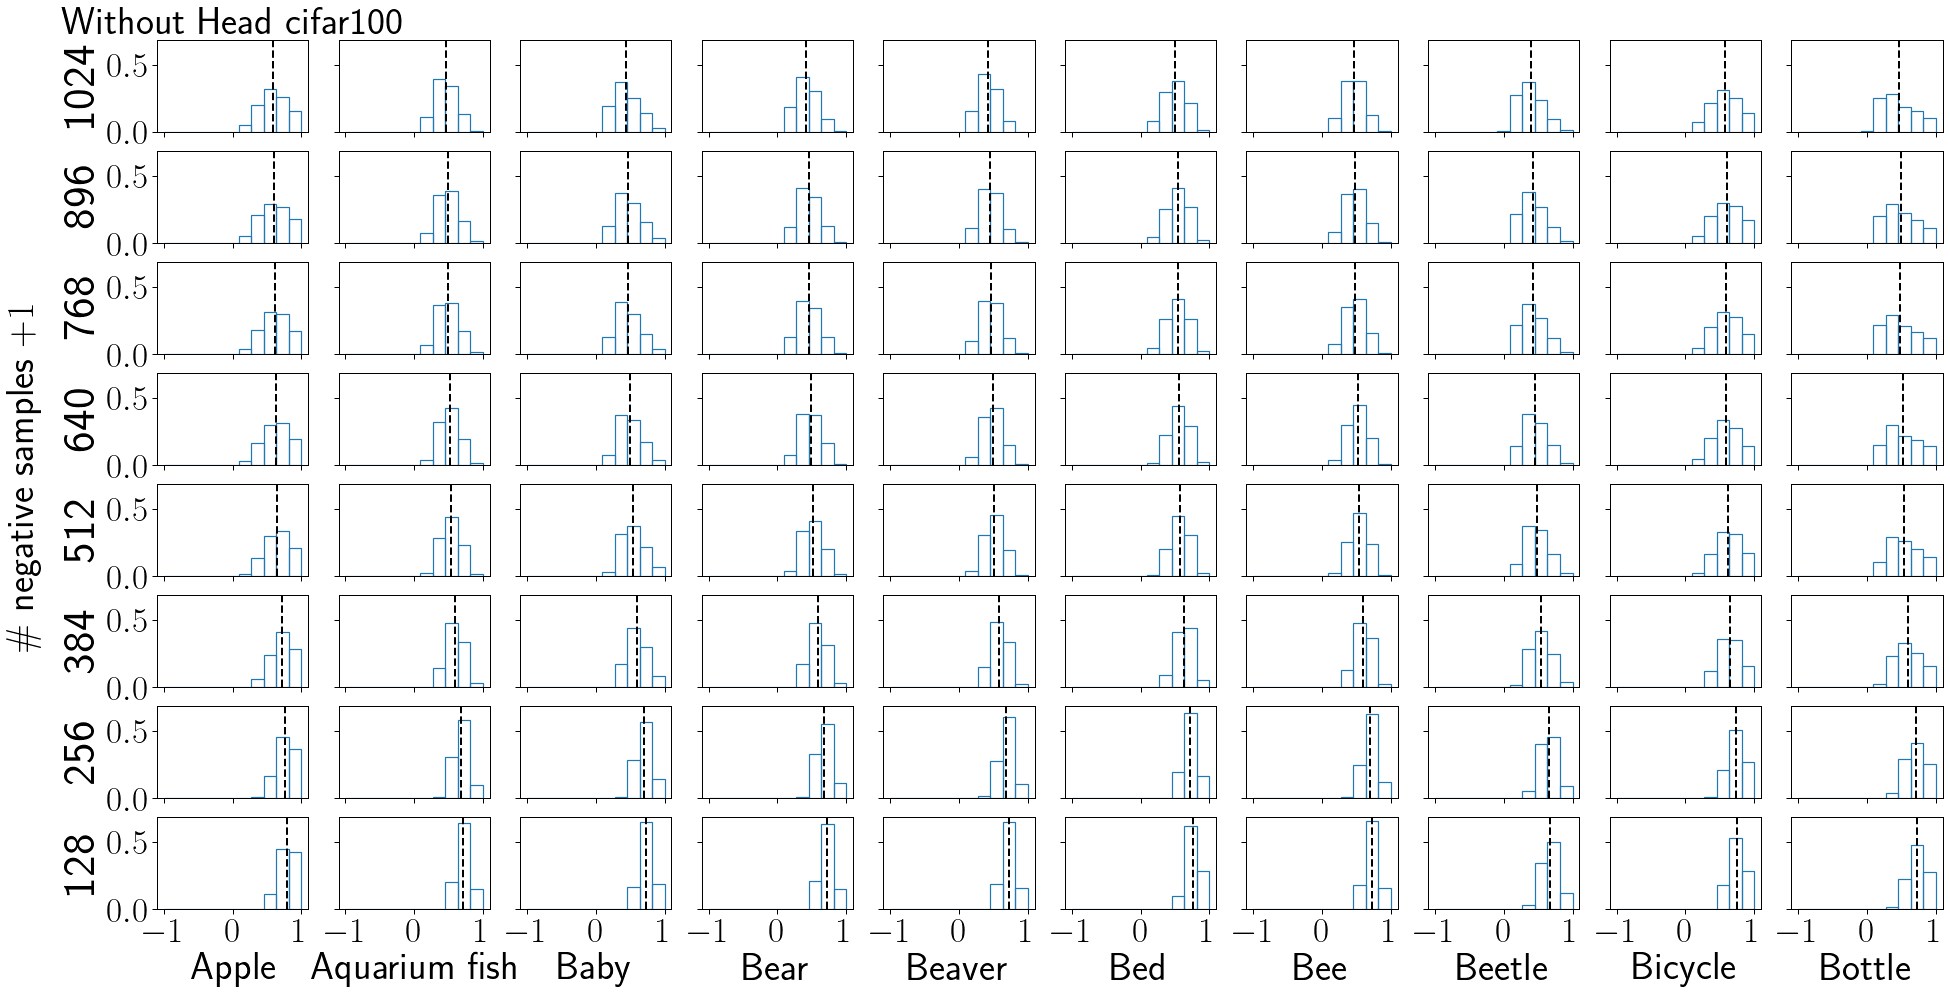

In [5]:
seed = 7

# store averaged cosine 
cosine_sims = {}
for dataset, f_d in features.items():
    cosine_sims[dataset] = {}

    for head_info, f_d_h in f_d.items():
        cosine_sims[dataset][head_info] = {}

        C = min(10, len(id2classes[dataset]))
        negs = list(sorted(f_d_h[seed]))

        fig, axes = plt.subplots(len(negs), C, figsize=(32, 16), sharex=True, sharey=True)

        for i, neg in enumerate(negs[::-1]):

            X_train, y_train, X_eval, y_eval = f_d_h[seed][neg]

            X_train_normalized = sklearn.preprocessing.normalize(X_train, axis=1)

            hist = []

            for c in range(C):
                X_train_c = X_train_normalized[y_train == c]
                cos_sim = X_train_c.dot(X_train_c.T)
                cos_sim = cos_sim[np.triu_indices(len(cos_sim), 1)].flatten()

                num_bins = int(np.log(len(cos_sim)))

                sns.histplot(cos_sim, bins=num_bins, stat="probability", ax=axes[i, c], fill=False, binrange=(-1., 1.))
                axes[i, c].axvline(cos_sim.mean(), color="k", linestyle="dashed", linewidth=2.)

        for r in range(len(negs)):
            for c in range(C):
                axes[r, c].set_xlabel("")
                axes[r, c].set_ylabel("")

        for i, class_name in enumerate(id2classes[dataset][:C]):
            axes[-1, i].set_xlabel(class_name.replace("_", " ").capitalize())

        for i, neg in enumerate(negs[::-1]):
            axes[i, 0].set_ylabel(neg, size="large")

        fig.text(0.06, 0.5, "\# negative samples $+ 1$", va="center", rotation="vertical")

        fname = "../../doc/figs/cos_hist_{}_{}_seed-{}.pdf".format(head_info, dataset, seed)
        plt.savefig(fname)

        axes[0, 0].set_title("{} {}".format(head_info, dataset))
        plt.show()


## relative change

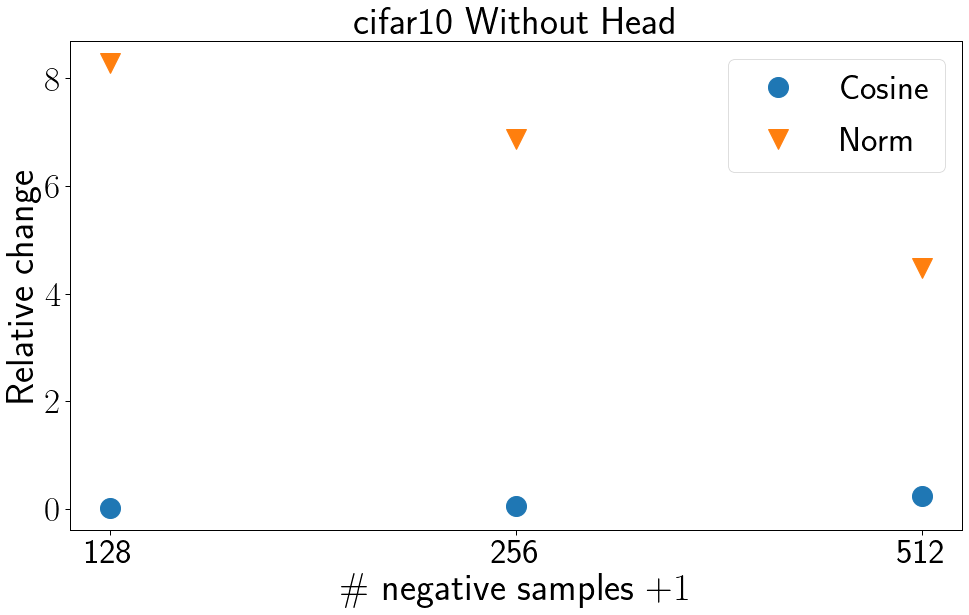

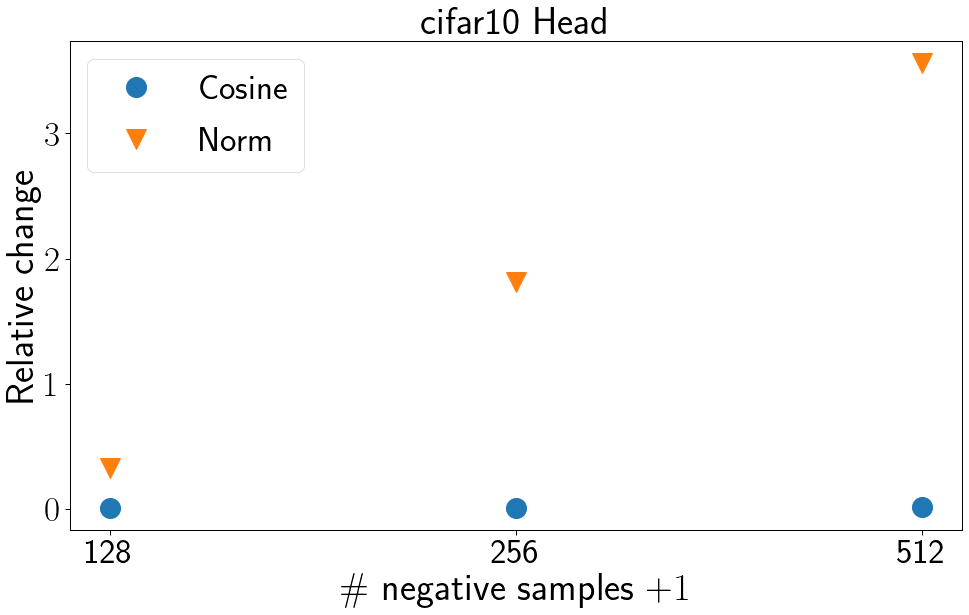

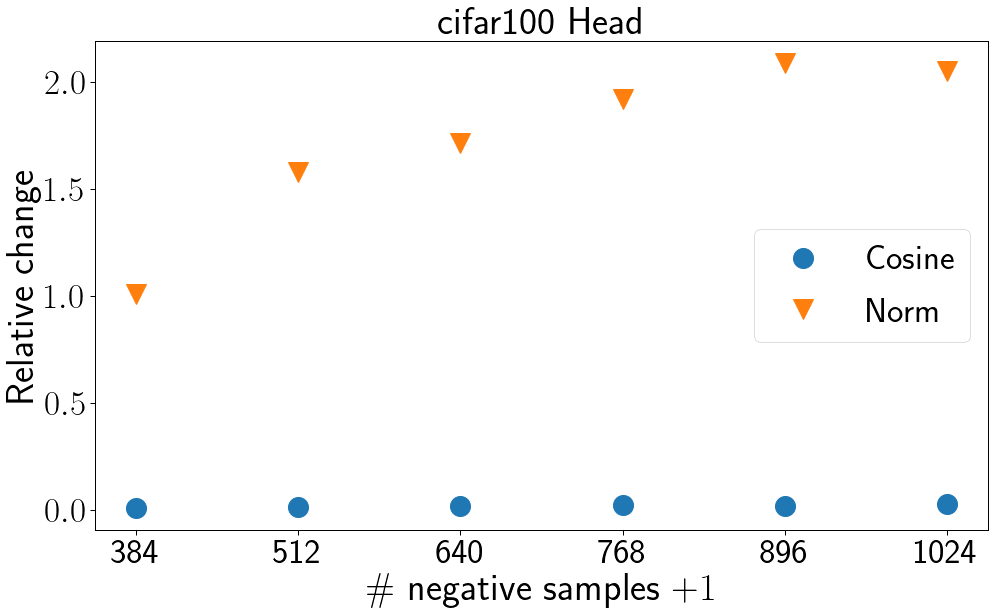

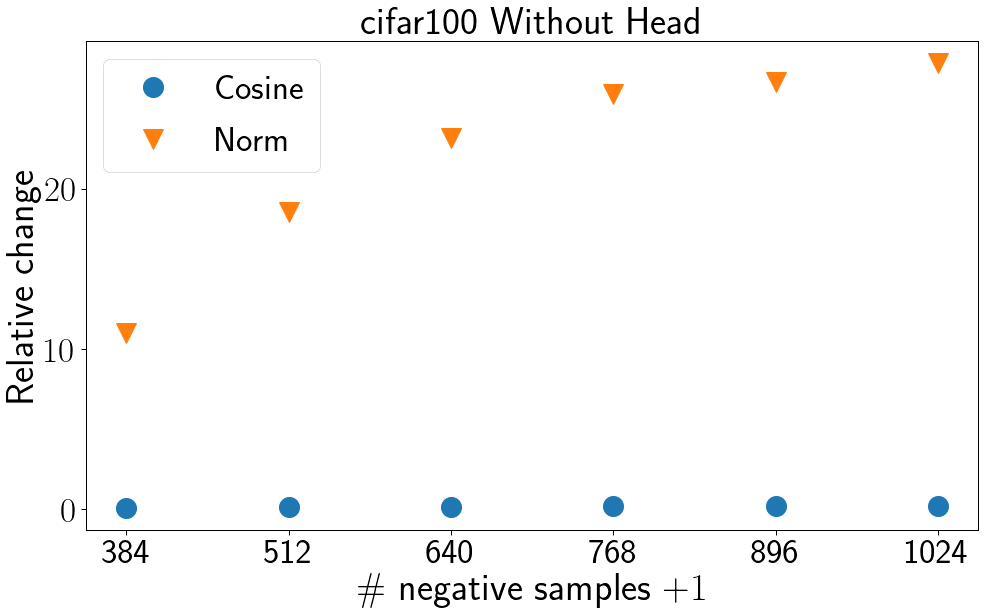

In [6]:
def get_value_hist(edges):
    results = [(edges[i] + edges[i + 1]) / 2. for i in range(len(edges) - 1)]

    return np.array(results)


for dataset, features_by_dataset in features.items():
    for head_info, f_d_h in features_by_dataset.items():
        fig, axes_ratio = plt.subplots(1, 1, figsize=(16, 9))

        cos_w_distance_by_seed = []
        norm_w_distance_by_seed = []

        for seed, f_d_h_s in f_d_h.items():
            negs = np.array(list(sorted(f_d_h_s)))

            cosine_hist_by_neg = []
            norms_by_neg = []

            for neg in negs:

                X_train, y_train, X_eval, y_eval = f_d_h_s[neg]

                C = len(np.unique(y_train))

                # norm
                norms_by_neg.append(np.sqrt(np.sum(X_train ** 2, axis=1)))

                X_train_normalized = sklearn.preprocessing.normalize(X_train, axis=1)

                # histogram for cosine similarity
                cos_hist = []
                for c in range(C):
                    X_train_c = X_train_normalized[y_train == c]
                    cos_sim = X_train_c.dot(X_train_c.T)
                    cos_sim = cos_sim[np.triu_indices(len(cos_sim), 1)].flatten()

                    cos_hist.append(
                        np.histogram(
                            cos_sim,
                            bins=int(np.log(len(cos_sim))),
                            range=(-1.0, 1.0),
                        )
                    )
                cosine_hist_by_neg.append(cos_hist)  # num-negs x C x 2

            # cosine W distance per class
            w_mean_over_C = []
            min_neg = negs[0]
            for cos_histogram in cosine_hist_by_neg[1:]:
                w_distance = []
                for c in range(len(cosine_hist_by_neg[0])):
                    base_values = get_value_hist(cosine_hist_by_neg[0][c][1])
                    base_weights = cosine_hist_by_neg[0][c][0] / np.sum(cosine_hist_by_neg[0][c][0])

                    values = get_value_hist(cos_histogram[c][1])
                    weights = cos_histogram[c][0] / np.sum(cos_histogram[c][0])

                    d = scipy.stats.wasserstein_distance(
                        base_values, values,
                        base_weights, weights
                    )
                    w_distance.append(d)

                w_mean_over_C.append(np.mean(w_distance))

            cos_w_distance_by_seed.append(w_mean_over_C)

            # histgram for norm
            # since norm is not bounded, decide the boundaries among k
            h_min = 10 ** 9
            h_max = 0.
            for norm_list in norms_by_neg:
                h_min = min(h_min, np.min(norm_list))
                h_max = max(h_max, np.max(norm_list))

            norms_hist_by_neg = []

            for norm_list in norms_by_neg:
                norms_hist_by_neg.append(
                    np.histogram(
                        norm_list,
                        bins=int(np.log(len(norm_list))),
                        range=(h_min, h_max),
                    )
                )

            # norm's W distance
            # base dist. 
            norm_w_distance = []

            base_weights = norms_hist_by_neg[0][0] / np.sum(norms_hist_by_neg[0][0])
            base_values = get_value_hist(norms_hist_by_neg[0][1])

            for norm_histogram in norms_hist_by_neg[1:]:
                values = get_value_hist(norm_histogram[1])

                weights = norm_histogram[0] / np.sum(norm_histogram[0])
                d = scipy.stats.wasserstein_distance(
                    base_values, values,
                    base_weights, weights

                )
                norm_w_distance.append(d)

            norm_w_distance_by_seed.append(norm_w_distance)

        # the smallest pair's distance is removed since the relative change is trivial: 0
        cos_w_distance = np.array(cos_w_distance_by_seed).mean(axis=0)
        cos_w_distance -= cos_w_distance[0]
        cos_w_distance = cos_w_distance[1:]

        norm_w_distance = np.array(norm_w_distance_by_seed).mean(axis=0)
        norm_w_distance -= norm_w_distance[0]
        norm_w_distance = norm_w_distance[1:]

        axes_ratio.errorbar(np.arange(len(negs) - 2), cos_w_distance, fmt="o", markersize=20, label="Cosine")
        axes_ratio.errorbar(np.arange(len(negs) - 2), norm_w_distance, fmt="v", markersize=20, label="Norm")

        axes_ratio.set_xticks(np.arange(len(negs) - 2))
        axes_ratio.set_xticklabels(negs[2:])

        axes_ratio.set_ylabel("Relative change")
        axes_ratio.set_xlabel("\# negative samples $+ 1$")

        plt.legend()

        fname = "../../doc/figs/wasserstein_distance_{}_{}.pdf".format(head_info, dataset)
        plt.savefig(fname)

        axes_ratio.set_title(f"{dataset} {head_info}")
        plt.show()
